In [1]:
# Move into the proper directory on LASSEN

import os
os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')


In [2]:
import data_generation
import constants
import fruit_spectra

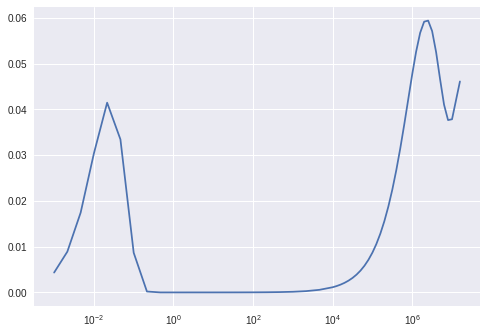

In [3]:
plt.plot(constants.Ebins, fruit_spectra.randFission())

plt.xscale("log")

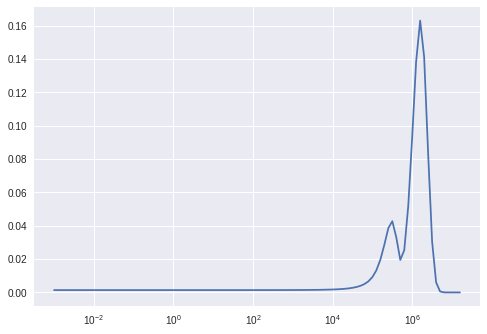

In [10]:
plt.plot(constants.Ebins, fruit_spectra.randGauss())

plt.xscale("log")

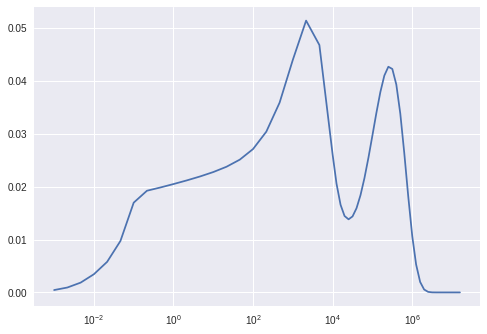

In [15]:
plt.plot(constants.Ebins, fruit_spectra.randHighEnergy())

plt.xscale("log")

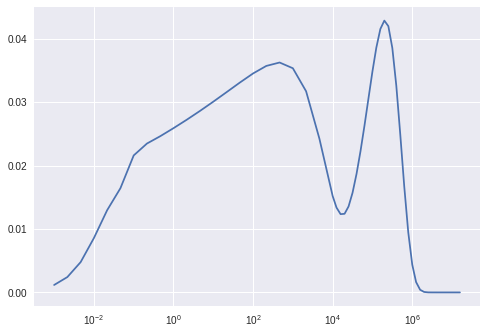

In [17]:
plt.plot(constants.Ebins, fruit_spectra.randEvap())

plt.xscale("log")

In [22]:
np.sum(fruit_spectra.randEvap())

1.0

In [13]:
T_0 = 2.53e-8
E_d = 7.07e-8

In [14]:

def thermal(E, T_0):
    spectra = ( (E / (np.power(T_0, 2)))*np.exp(-E/T_0) )
    return spectra / np.sum(spectra)

def epithermal(E, E_d, b, beta_p):
    spectra = ( (1 - np.exp( -np.power((E/E_d), 2) )) * np.power(E, (b-1)) * np.exp(-E/beta_p) )
    return spectra / np.sum(spectra)
    
def fast_fission(E, alpha, beta):
    spectra = (np.power(E, alpha)) * np.exp(-E / beta)
    return spectra / np.sum(spectra)

def fast_evaporation(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev) 
    return spectra / np.sum(spectra)

def fast_gaussian(E, E_m, sigma):
    spectra = np.exp( - np.power((E - E_m), 2) / (2 * np.power((sigma * E_m), 2) ) )
    return spectra / np.sum(spectra)

def fast_high_energy(E, T_ev):
    spectra = (E / (np.power(T_ev, 2))) * np.exp(-E / T_ev)
    return spectra / np.sum(spectra)

def high_energy_func(E, T_hi):
    spectra = (E / (np.power(T_hi, 2))) * np.exp(-E / T_hi)
    return spectra / np.sum(spectra)


In [15]:
def fission(E, P_th, P_e, b, beta_p, alpha, beta):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_fission(E, alpha, beta)
    return spectra

def evaporation(E, P_th, P_e, b, beta_p, T_ev):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_evaporation(E, T_ev)
    return spectra

def gaussian(E, P_th, P_e, b, beta_p, E_m, sigma):
    E = E * 1e-6
    while P_th + P_e > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
    
    P_f = 1 - P_th - P_e
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_gaussian(E, E_m, sigma)
    return spectra

def high_energy(E, P_th, P_e, P_f, b, beta_p, T_ev, T_hi):
    E = E * 1e-6
    while P_th + P_e + P_f > 1:
        P_th = P_th / 2.0
        P_e = P_e / 2.0
        P_f = P_f / 2.0
    P_he = 1 - (P_th + P_e + P_f)
    
    if T_hi < T_ev:
        T_hi = 10**(np.log10(T_ev / T_hi))
    
    spectra = P_th * thermal(E, T_0) + P_e * epithermal(E, E_d, b, beta_p) + P_f * fast_high_energy(E, T_ev) + P_he * high_energy_func(E, T_hi)
    return spectra



In [16]:
import sys
sys.path.append('./FRUIT')
import fruit_fittings

import data_generation
import constants

import random

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [17]:
YMAX = 1
def plot_loghist(ax, x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=logbins, weights=weights)
    ax.set_xscale('log')
    ax.set_ylim(0,YMAX)

def plot_hist(ax, x, bins, range):
    weights = np.ones_like(x) / len(x)
    ax.hist(x, bins=bins, range = range, weights = weights)
    ax.set_ylim(0,YMAX)
    return

fittings = fruit_fittings.FRUIT_FITTINGS

In [18]:
# Making Histogram of Fission Spectra Parameter Fitting

# Fission : P_th, P_e, b, beta_p, alpha, beta
P_th_F, P_e_F, P_f_F, b_F, beta_p_F, alpha_F, beta_F = [], [], [], [], [], [], []

# Evaporation : P_th, P_e, b, beta_p, T_ev
P_th_E, P_e_E, P_f_E, b_E, beta_p_E, T_ev_E = [], [], [], [], [], []

# Gaussian : P_th, P_e, b, beta_p, E_m, sigma
P_th_G, P_e_G, P_f_G, b_G, beta_p_G, E_m_G, sigma_G = [], [], [], [], [], [], []

# High Energy : P_th, P_e, P_f, b, beta_p, T_ev, T_hi
P_th_HE, P_e_HE, P_f_HE, P_hi_HE, b_HE, beta_p_HE, T_ev_HE, T_hi_HE = [], [], [], [], [], [], [], []

for fit in fittings:
    
    if fit["fit_type"] in "fission":
        
        P_th = fit["params"][0]
        P_e = fit["params"][1]
        while P_th + P_e > 1:
            P_th = P_th / 2.0
            P_e = P_e / 2.0
        P_f = 1 - P_th - P_e
            
        P_th_F.append(P_th) 
        P_e_F.append(P_e)
        P_f_F.append(P_f)
        b_F.append(fit["params"][2]) 
        beta_p_F.append(fit["params"][3]) 
        alpha_F.append(fit["params"][4]) 
        beta_F.append(fit["params"][5]) 
        
    elif fit["fit_type"] in "evaporation":
        P_th = fit["params"][0]
        P_e = fit["params"][1]
        while P_th + P_e > 1:
            P_th = P_th / 2.0
            P_e = P_e / 2.0
        P_f = 1 - P_th - P_e
            
        #P_th_HE.append(P_th) 
        #P_e_HE.append(P_e)
        #P_f_HE.append(P_f)
        #b_HE.append(fit["params"][2]) 
        #beta_p_HE.append(fit["params"][3]) 
        #T_ev_HE.append(fit["params"][4])
        print(fit["params"])
        
    elif fit["fit_type"] in "gaussian":
        # P_th, P_e, b, beta_p, E_m, sigma
        P_th = fit["params"][0]
        P_e = fit["params"][1]
        while P_th + P_e > 1:
            P_th = P_th / 2.0
            P_e = P_e / 2.0
        P_f = 1 - P_th - P_e
            
        P_th_G.append(P_th)
        P_e_G.append(P_e)
        P_f_G.append(P_f)
        b_G.append(fit["params"][2]) 
        beta_p_G.append(fit["params"][3]) 
        E_m_G.append(fit["params"][4])
        sigma_G.append(fit["params"][5])
        
    elif fit["fit_type"] in "high_energy":
        # P_th, P_e, P_f, b, beta_p, T_ev, T_hi
        P_th = fit["params"][0]
        P_e = fit["params"][1]
        P_f = fit["params"][2]
        while P_th + P_e + P_f > 1:
            P_th = P_th / 2.0
            P_e = P_e / 2.0
            P_f = P_f / 2.0
        P_hi = 1 - (P_th + P_e + P_f)
            
        P_th_HE.append(P_th) 
        P_e_HE.append(P_e)
        P_f_HE.append(P_f)
        P_hi_HE.append(P_hi)
        b_HE.append(fit["params"][3]) 
        beta_p_HE.append(fit["params"][4])
        
        T_ev = fit["params"][5]
        T_hi = fit["params"][6]
        if T_hi < T_ev:
            T_hi = 10**(np.log10(T_ev / T_hi))
        
        T_ev_HE.append(T_ev)
        T_hi_HE.append(T_hi)
        
        

[0.60826239 0.26103094 0.93963753 0.02670969 0.1262779 ]


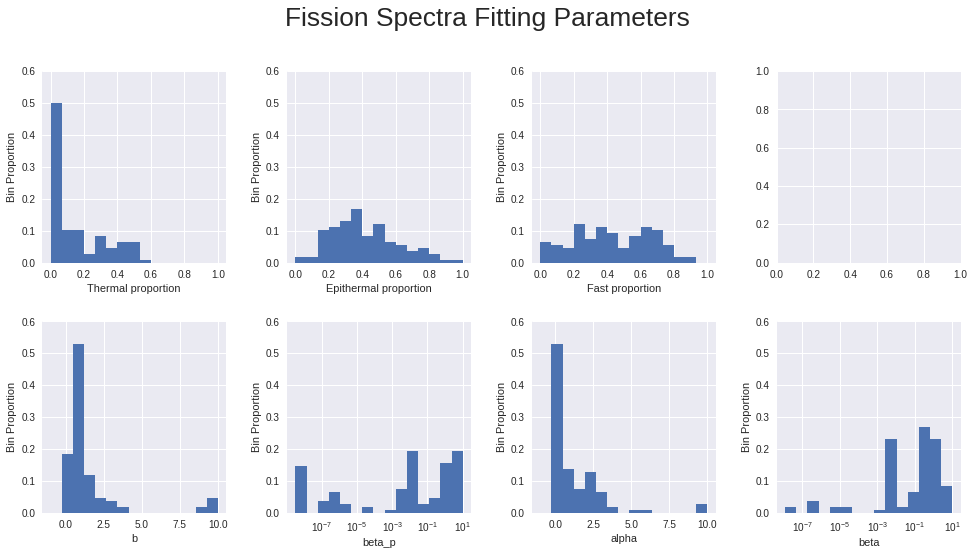

In [19]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 15

YMAX = 0.6

plot_hist(axs[0][0], P_th_F, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Bin Proportion")

plot_hist(axs[0][1], P_e_F, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Bin Proportion")

plot_hist(axs[0][2], P_f_F, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Bin Proportion")

plot_hist(axs[1][0], b_F, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Bin Proportion")

plot_loghist(axs[1][1], beta_p_F, bins = BINS)
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Bin Proportion")

plot_hist(axs[1][2], alpha_F, bins = BINS, range = (-1, 10))
axs[1][2].set_xlabel("alpha")
axs[1][2].set_ylabel("Bin Proportion")

plot_loghist(axs[1][3], beta_F, bins = BINS)
axs[1][3].set_xlabel("beta")
axs[1][3].set_ylabel("Bin Proportion")

fig.suptitle("Fission Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("FissionParams.png", dpi = 300)


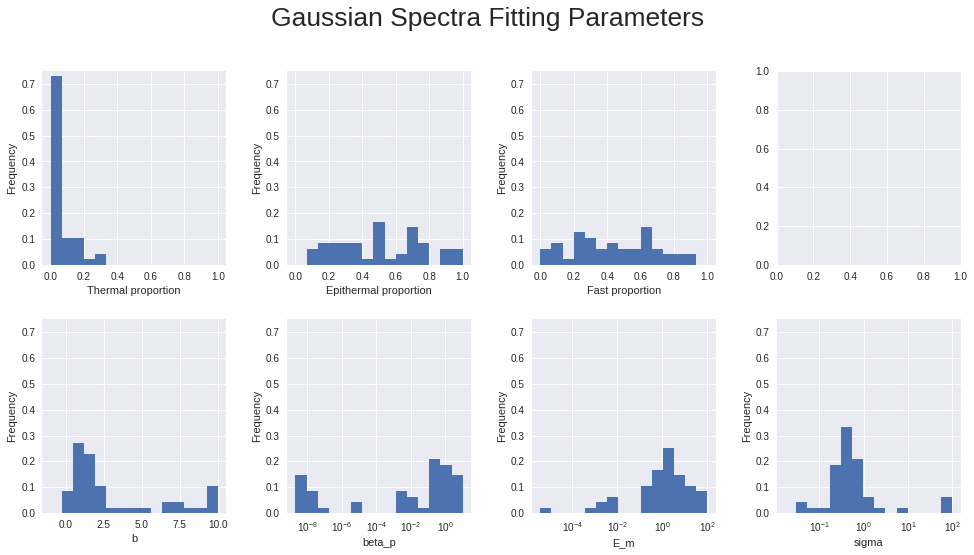

In [20]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 15
YMAX = 0.75

plot_hist(axs[0][0], P_th_G, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Frequency")

plot_hist(axs[0][1], P_e_G, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Frequency")

plot_hist(axs[0][2], P_f_G, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Frequency")

plot_hist(axs[1][0], b_G, bins = BINS, range = (-1, 10))
#axs[1][0].hist(b_G, bins = BINS, range = (0, 2))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Frequency")

plot_loghist(axs[1][1], beta_p_G, bins = BINS)
#axs[1][1].hist(beta_p_G, bins = BINS, range = (0, 2))
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Frequency")

plot_loghist(axs[1][2], E_m_G, bins = BINS)
#axs[1][2].hist(E_m_G, bins = BINS, range = (0, 100))
axs[1][2].set_xlabel("E_m")
axs[1][2].set_ylabel("Frequency")

plot_loghist(axs[1][3], sigma_G, bins = BINS)
#axs[1][3].hist(sigma_G, bins = BINS, range = (0, 100))
axs[1][3].set_xlabel("sigma")
axs[1][3].set_ylabel("Frequency")

fig.suptitle("Gaussian Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("GaussianParams.png", dpi = 300)


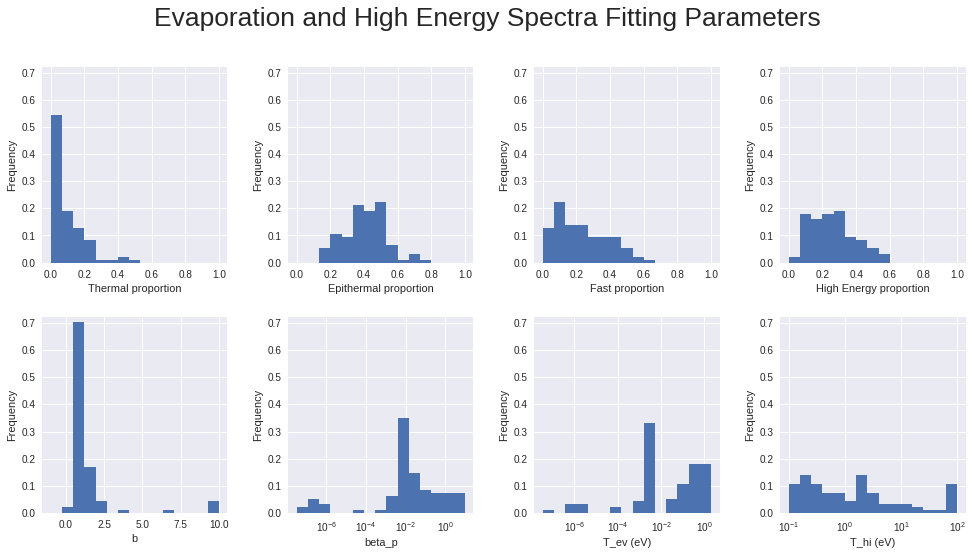

In [21]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
BINS = 15
YMAX = 0.72

plot_hist(axs[0][0], P_th_HE, bins = BINS, range = (0,1))
axs[0][0].set_xlabel("Thermal proportion")
axs[0][0].set_ylabel("Frequency")

plot_hist(axs[0][1], P_e_HE, bins = BINS, range = (0,1))
axs[0][1].set_xlabel("Epithermal proportion")
axs[0][1].set_ylabel("Frequency")

plot_hist(axs[0][2], P_f_HE, bins = BINS, range = (0,1))
axs[0][2].set_xlabel("Fast proportion")
axs[0][2].set_ylabel("Frequency")

plot_hist(axs[0][3], P_hi_HE, bins = BINS, range = (0,1))
axs[0][3].set_xlabel("High Energy proportion")
axs[0][3].set_ylabel("Frequency")

plot_hist(axs[1][0], b_HE, bins = BINS, range = (-1, 10))
axs[1][0].set_xlabel("b")
axs[1][0].set_ylabel("Frequency")

plot_loghist(axs[1][1], beta_p_HE, bins = BINS)
axs[1][1].set_xlabel("beta_p")
axs[1][1].set_ylabel("Frequency")

plot_loghist(axs[1][2], T_ev_HE, bins = BINS)
axs[1][2].set_xlabel("T_ev (eV)")
axs[1][2].set_ylabel("Frequency")

plot_loghist(axs[1][3], T_hi_HE, bins = BINS)
axs[1][3].set_xlabel("T_hi (eV)")
axs[1][3].set_ylabel("Frequency")

fig.suptitle("Evaporation and High Energy Spectra Fitting Parameters")
plt.tight_layout()

plt.savefig("EvapHighEnergyParams.png", dpi = 300)


/var/folders/66/dcsv62x14w98n4s5n8mdhpvc0000gn/T/ipykernel_91213/1442023876.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(np.array(T_ev_HE), np.array(T_hi_HE), bins = (logbinsEV, logbinsHI))


(0.0001, 10.0)

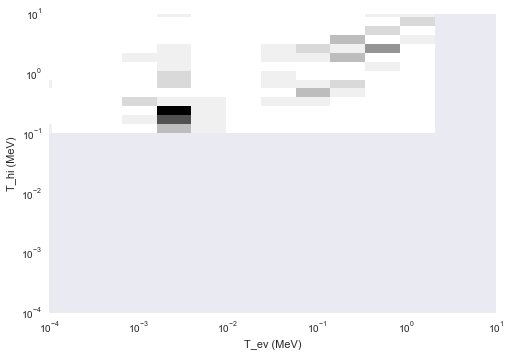

In [15]:
hist, bins = np.histogram(T_ev_HE, bins=20)
logbinsEV = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

hist, bins = np.histogram(T_hi_HE, bins=20)
logbinsHI = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.hist2d(np.array(T_ev_HE), np.array(T_hi_HE), bins = (logbinsEV, logbinsHI))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("T_ev (MeV)")
plt.ylabel("T_hi (MeV)")
plt.xlim(10e-5, 10e0)
plt.ylim(10e-5, 10e0)

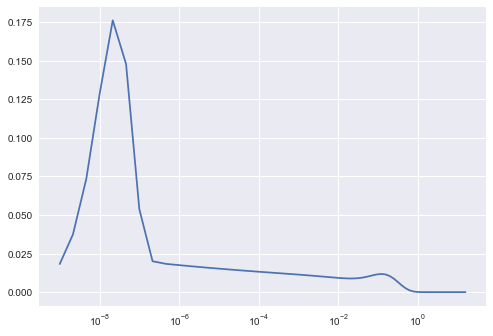

In [243]:
plt.plot(constants.Ebins / 1e6, evaporation(constants.Ebins, 0.60826239, 0.26103094, 0.93963753, 0.02670969, 0.1262779))
plt.xscale("log")

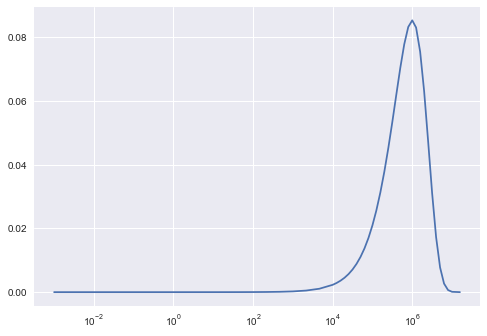

In [209]:
plt.plot(constants.Ebins, high_energy_func(constants.Ebins / 1e6, 1))
plt.xscale("log")

In [210]:

randHighEnergy = lambda : high_energy(constants.Ebins, random.choice(P_th), random.choice(P_e),random.choice(P_f),random.choice(T_0),random.choice(E_d),random.choice(b),random.choice(beta_p),random.choice(T_ev),random.choice(T_hi))


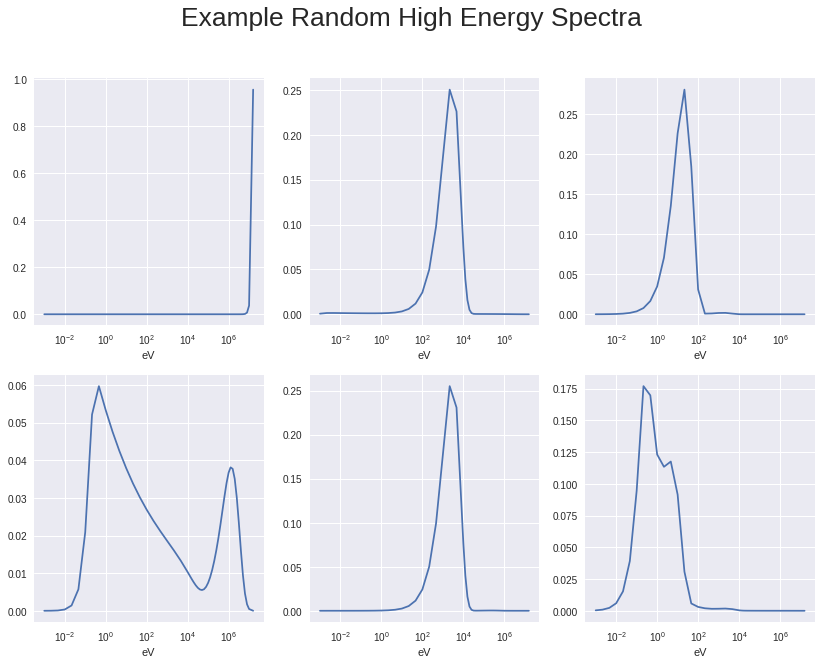

In [110]:
fig, axs = plt.subplots(2,3, figsize=(14,10))

fig.suptitle("Example Random High Energy Spectra")

for row in axs:
    for ax in row:
        ax.plot(constants.Ebins, randHighEnergy())
        ax.set_xscale("log")
        ax.set_xlabel("eV")

In [1]:
import fruit_spectra

In [4]:
plt.plot(fruit_spectra.randFission())

NameError: name 'plt' is not defined

In [28]:
for fit in fruit_spectra.fittings:
    if fit["fit_type"] in "fission":
        print(fit)

{'fit_type': 'fission', 'params': array([3.11493553e-05, 9.92802194e-01, 2.48716722e+00, 1.27763602e+00,
       9.99999997e+00, 1.81129577e-01])}
{'fit_type': 'fission', 'params': array([1.37779737e-22, 2.50737727e-01, 2.30866200e+00, 8.96192554e-01,
       5.64790804e+00, 7.89990811e-01])}
{'fit_type': 'fission', 'params': array([0.08390954, 0.22271371, 1.07089239, 0.0180068 , 1.21036031,
       1.38282154])}
{'fit_type': 'fission', 'params': array([9.67101094e-02, 5.90667636e-01, 9.81496690e-01, 7.26457571e+00,
       2.51385065e-01, 4.61539831e-03])}
{'fit_type': 'fission', 'params': array([0.17225032, 0.59914092, 0.96930635, 0.00770151, 0.14030047,
       1.84924637])}
{'fit_type': 'fission', 'params': array([ 0.01706205,  0.58430411,  2.29211577,  2.14733722, -0.07103473,
        1.31676586])}
{'fit_type': 'fission', 'params': array([0.44265553, 0.16705621, 0.58921411, 9.98899498, 0.403802  ,
       3.75600844])}
{'fit_type': 'fission', 'params': array([2.89532434e-01, 1.25615951e

In [23]:
import data_generation

In [25]:
x, y = data_generation.FRUIT(100, [])

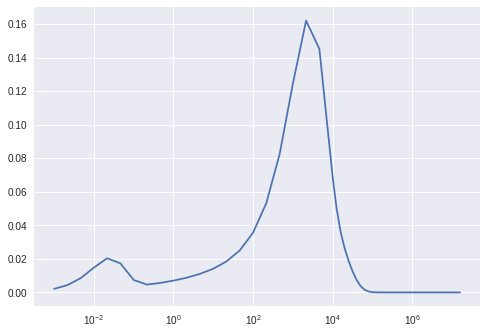

In [29]:
plt.plot(constants.Ebins, y[0])
plt.xscale("log")